# European Sovereign States Web Scraping and Analysis

This notebook scrapes data from Wikipedia's list of European sovereign states, processes it into a Pandas DataFrame, and performs statistical analysis with visualizations.

## 1. Import Required Libraries

Import necessary libraries for web scraping, data manipulation, and visualization.

In [36]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Scrape Wikipedia Table

Define a function to fetch the Wikipedia page and extract the first table containing European sovereign states data.

In [37]:
def scrape_european_countries():
    """
    Scrapes the Wikipedia article for European sovereign states.
    Collects: English common name, formal name, area (km2), area (mi2), 
    population, and EU membership status based on the EU column content.
    
    Returns:
        pandas.DataFrame: DataFrame containing the scraped data
    """
    url = "https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_Europe"
    
    # Fetch the page
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    # Parse HTML
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all tables with wikitable class
    tables = soup.find_all('table', {'class': 'wikitable'})
    
    # Initialize lists to store data
    data = {
        'English Common Name': [],
        'Formal Name': [],
        'Area (km2)': [],
        'Area (mi2)': [],
        'Population': [],
        'EU Member': []
    }
    
    # Use the first wikitable which contains the sovereign states
    target_table = tables[0] if tables else None
    
    if not target_table:
        print("Could not find any wikitable")
        return pd.DataFrame()
    
    # Get all rows
    rows = target_table.find_all('tr')
    
    for row in rows:
        cells = row.find_all('td')
        if len(cells) < 6:
            continue
        
        # Find the cell with country name
        name_cell = None
        name_cell_idx = 0
        
        for idx, cell in enumerate(cells[:3]):
            text = cell.get_text().strip()
            if text and not text.replace(',', '').replace('.', '').isdigit():
                if len(text) > 2 and any(c.isalpha() for c in text):
                    name_cell = cell
                    name_cell_idx = idx
                    break
        
        if not name_cell:
            continue
        
        # Extract country names
        name_text = name_cell.get_text(separator='\n').strip()
        lines = [line.strip() for line in name_text.split('\n') if line.strip()]
        
        if not lines:
            continue
        
        clean_lines = []
        for line in lines:
            cleaned = re.sub(r'\[.*?\]', '', line).strip()
            if cleaned:
                clean_lines.append(cleaned)
        
        if not clean_lines:
            continue
        
        first_line = clean_lines[0]
        
        code_match = re.search(r'\s+([A-Z]{3})$', first_line)
        if code_match:
            name_part = first_line[:code_match.start()].strip()
        else:
            name_part = first_line
        
        common_name = name_part
        formal_name = name_part
        
        formal_patterns = [
            (r'^(.+?)\s+(Republic of .+)$', 1, 2),
            (r'^(.+?)\s+(Kingdom of .+)$', 1, 2),
            (r'^(.+?)\s+(Principality of .+)$', 1, 2),
            (r'^(.+?)\s+(Grand Duchy of .+)$', 1, 2),
            (r'^(.+?)\s+(Federal Republic of .+)$', 1, 2),
            (r'^(.+?)\s+(Hellenic Republic)$', 1, 2),
            (r'^(.+?)\s+(Swiss Confederation)$', 1, 2),
            (r'^(.+?)\s+(Russian Federation)$', 1, 2),
            (r'^(.+?)\s+(French Republic)$', 1, 2),
            (r'^(.+?)\s+(Italian Republic)$', 1, 2),
            (r'^(.+?)\s+(Portuguese Republic)$', 1, 2),
            (r'^(.+?)\s+(Slovak Republic)$', 1, 2),
            (r'^(.+?)\s+(Czech Republic)$', 1, 2),
            (r'^(.+?)\s+(United Kingdom of .+)$', 1, 2),
        ]
        
        for pattern, common_idx, formal_idx in formal_patterns:
            match = re.match(pattern, name_part)
            if match:
                common_name = match.group(common_idx).strip()
                formal_name = match.group(formal_idx).strip()
                break
        
        if len(common_name) < 2:
            continue
        
        # Initialize variables
        population = ''
        area_km2 = ''
        area_mi2 = ''
        is_eu_member = 'N'
        
        # Process each cell to extract data
        for idx, cell in enumerate(cells):
            cell_text = cell.get_text().strip()
            cell_text_clean = re.sub(r'\[.*?\]', '', cell_text)
            
            # Check EU membership column
            if cell_text_clean.strip().lower() == 'yes':
                is_eu_member = 'Y'
                continue
            
            # Check for area (contains km² or km2 or sq mi)
            if ('km' in cell_text_clean.lower() and ('sq' in cell_text_clean.lower() or 'mi' in cell_text_clean.lower())) or \
               ('km²' in cell_text_clean or 'km2' in cell_text_clean):
                # Extract km2 value
                km2_match = re.search(r'([\d,]+(?:\.\d+)?)\s*km', cell_text_clean, re.IGNORECASE)
                if km2_match:
                    area_km2 = km2_match.group(1).replace(',', '')
                
                # Extract sq mi value
                mi2_match = re.search(r'\(([\d,]+(?:\.\d+)?)\s*sq\s*mi', cell_text_clean, re.IGNORECASE)
                if mi2_match:
                    area_mi2 = mi2_match.group(1).replace(',', '')
                continue
            
            # Check for population (pure number)
            if not population:
                # Match cells that are primarily numbers
                clean_num = cell_text_clean.replace(',', '').strip()
                if clean_num.isdigit():
                    num_val = int(clean_num)
                    # Population typically between 500 and 1.5 billion
                    if num_val > 100 and num_val < 1500000000:
                        population = str(num_val)
        
        data['English Common Name'].append(common_name)
        data['Formal Name'].append(formal_name)
        data['Area (km2)'].append(area_km2)
        data['Area (mi2)'].append(area_mi2)
        data['Population'].append(population)
        data['EU Member'].append(is_eu_member)
    
    return pd.DataFrame(data)

# Scrape the data
df = scrape_european_countries()
print(f"Scraped {len(df)} countries")
print(f"EU Members found: {(df['EU Member'] == 'Y').sum()}")
print(f"Rows with Area data: {(df['Area (km2)'] != '').sum()}")
df.head(15)

Scraped 50 countries
EU Members found: 27
Rows with Area data: 50


,English Common Name,Formal Name,Area (km2),Area (mi2),Population,EU Member
0,Albania,Albania,28748,11100,2854710,N
1,Andorra,Andorra,468,181,79034,N
2,Armenia,Armenia,29743,11484,2790974,N
3,Austria,Austria,83871,32383,8922082,Y
4,Azerbaijan,Azerbaijan,86600,33436,10312992,N
5,Belarus,Belarus,207600,80155,9578167,N
6,Belgium,Belgium,30528,11787,11611419,Y
7,Bosnia and Herzegovina,Bosnia and Herzegovina,51197,19767,3270943,N
8,Bulgaria,Bulgaria,110879,42811,6885868,Y
9,Croatia,Croatia,56594,21851,4060135,Y


## 3. Data Cleaning and Type Conversion

Clean the data by removing commas, special characters, and convert Area and Population columns to numeric types.

In [38]:
def clean_numeric(value):
    """
    Clean a string value and convert to numeric.
    Removes commas, spaces, and other non-numeric characters.
    """
    if pd.isna(value) or value == '':
        return None
    # Convert to string and remove commas, spaces, and other characters
    value_str = str(value)
    # Keep only digits and decimal point
    cleaned = re.sub(r'[^\d.]', '', value_str)
    if cleaned == '':
        return None
    try:
        return float(cleaned)
    except ValueError:
        return None

# Clean and convert numeric columns
df['Area (km2)'] = df['Area (km2)'].apply(clean_numeric)
df['Area (mi2)'] = df['Area (mi2)'].apply(clean_numeric)
df['Population'] = df['Population'].apply(clean_numeric)

# Convert to appropriate numeric types
df['Area (km2)'] = pd.to_numeric(df['Area (km2)'], errors='coerce')
df['Area (mi2)'] = pd.to_numeric(df['Area (mi2)'], errors='coerce')
df['Population'] = pd.to_numeric(df['Population'], errors='coerce')

# Display the cleaned DataFrame
print("DataFrame Info:")
print(df.dtypes)
print(f"\nShape: {df.shape}")
print("\nFirst 10 rows of cleaned data:")
df.head(10)

DataFrame Info:
English Common Name     object
Formal Name             object
Area (km2)             float64
Area (mi2)             float64
Population             float64
EU Member               object
dtype: object

Shape: (50, 6)

First 10 rows of cleaned data:


,English Common Name,Formal Name,Area (km2),Area (mi2),Population,EU Member
0,Albania,Albania,28748.0,11100.0,2854710.0,N
1,Andorra,Andorra,468.0,181.0,79034.0,N
2,Armenia,Armenia,29743.0,11484.0,2790974.0,N
3,Austria,Austria,83871.0,32383.0,8922082.0,Y
4,Azerbaijan,Azerbaijan,86600.0,33436.0,10312992.0,N
5,Belarus,Belarus,207600.0,80155.0,9578167.0,N
6,Belgium,Belgium,30528.0,11787.0,11611419.0,Y
7,Bosnia and Herzegovina,Bosnia and Herzegovina,51197.0,19767.0,3270943.0,N
8,Bulgaria,Bulgaria,110879.0,42811.0,6885868.0,Y
9,Croatia,Croatia,56594.0,21851.0,4060135.0,Y


## 4. Display Complete DataFrame

Show all countries with their data including EU membership status.

In [39]:
# Display complete DataFrame
print(f"Total countries: {len(df)}")
print(f"EU Members: {(df['EU Member'] == 'Y').sum()}")
print(f"Non-EU Members: {(df['EU Member'] == 'N').sum()}")
print("\nComplete DataFrame:")
df

Total countries: 50
EU Members: 27
Non-EU Members: 23

Complete DataFrame:


,English Common Name,Formal Name,Area (km2),Area (mi2),Population,EU Member
0,Albania,Albania,28748.00,11100.00,2854710.0,N
1,Andorra,Andorra,468.00,181.00,79034.0,N
2,Armenia,Armenia,29743.00,11484.00,2790974.0,N
3,Austria,Austria,83871.00,32383.00,8922082.0,Y
4,Azerbaijan,Azerbaijan,86600.00,33436.00,10312992.0,N
5,Belarus,Belarus,207600.00,80155.00,9578167.0,N
6,Belgium,Belgium,30528.00,11787.00,11611419.0,Y
7,Bosnia and Herzegovina,Bosnia and Herzegovina,51197.00,19767.00,3270943.0,N
8,Bulgaria,Bulgaria,110879.00,42811.00,6885868.0,Y
9,Croatia,Croatia,56594.00,21851.00,4060135.0,Y


## 5. Data Summary Statistics

Provide summary statistics including count, mean, std, min, max, and quartiles for numeric columns.

In [40]:
# Summary statistics for numeric columns
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

# Using describe() for comprehensive statistics
summary = df[['Area (km2)', 'Area (mi2)', 'Population']].describe()
print("\nDescriptive Statistics:")
print(summary)

# Additional statistics
print("\n" + "-" * 60)
print("Additional Statistics:")
print("-" * 60)
print(f"\nMean Area (km2): {df['Area (km2)'].mean():,.2f}")
print(f"Median Area (km2): {df['Area (km2)'].median():,.2f}")
print(f"Total Area (km2): {df['Area (km2)'].sum():,.2f}")

print(f"\nMean Population: {df['Population'].mean():,.0f}")
print(f"Median Population: {df['Population'].median():,.0f}")
print(f"Total Population: {df['Population'].sum():,.0f}")

print(f"\nVariance of Area (km2): {df['Area (km2)'].var():,.2f}")
print(f"Variance of Population: {df['Population'].var():,.2f}")

summary

SUMMARY STATISTICS

Descriptive Statistics:
         Area (km2)    Area (mi2)    Population
count  5.000000e+01  5.000000e+01  5.000000e+01
mean   5.358755e+05  2.069027e+05  1.730495e+07
std    2.424731e+06  9.361938e+05  2.873169e+07
min    4.900000e-01  1.900000e-01  5.110000e+02
25%    2.993925e+04  1.155975e+04  2.107350e+06
50%    6.998650e+04  2.702200e+04  5.695116e+06
75%    2.423052e+05  9.355425e+04  1.133625e+07
max    1.709824e+07  6.601668e+06  1.451028e+08

------------------------------------------------------------
Additional Statistics:
------------------------------------------------------------

Mean Area (km2): 535,875.51
Median Area (km2): 69,986.50
Total Area (km2): 26,793,775.49

Mean Population: 17,304,945
Median Population: 5,695,116
Total Population: 865,247,260

Variance of Area (km2): 5,879,319,957,373.24
Variance of Population: 825,510,075,182,815.38


,Area (km2),Area (mi2),Population
count,5.000000e+01,5.000000e+01,5.000000e+01
mean,5.358755e+05,2.069027e+05,1.730495e+07
std,2.424731e+06,9.361938e+05,2.873169e+07
min,4.900000e-01,1.900000e-01,5.110000e+02
25%,2.993925e+04,1.155975e+04,2.107350e+06
50%,6.998650e+04,2.702200e+04,5.695116e+06
75%,2.423052e+05,9.355425e+04,1.133625e+07
max,1.709824e+07,6.601668e+06,1.451028e+08


## 6. Correlation Analysis

Calculate the Pearson correlation coefficient between Area (km2) and Population.

In [41]:
# Calculate correlation between Area and Population
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Pearson correlation coefficient
correlation = df['Area (km2)'].corr(df['Population'])
print(f"\nPearson Correlation between Area (km2) and Population: {correlation:.4f}")

# Interpretation
if correlation > 0.7:
    interpretation = "Strong positive correlation"
elif correlation > 0.4:
    interpretation = "Moderate positive correlation"
elif correlation > 0:
    interpretation = "Weak positive correlation"
elif correlation > -0.4:
    interpretation = "Weak negative correlation"
elif correlation > -0.7:
    interpretation = "Moderate negative correlation"
else:
    interpretation = "Strong negative correlation"

print(f"Interpretation: {interpretation}")

# Full correlation matrix for numeric columns
print("\n" + "-" * 60)
print("Correlation Matrix:")
print("-" * 60)
correlation_matrix = df[['Area (km2)', 'Area (mi2)', 'Population']].corr()
correlation_matrix

CORRELATION ANALYSIS

Pearson Correlation between Area (km2) and Population: 0.6825
Interpretation: Moderate positive correlation

------------------------------------------------------------
Correlation Matrix:
------------------------------------------------------------


,Area (km2),Area (mi2),Population
Area (km2),1.000000,1.000000,0.682452
Area (mi2),1.000000,1.000000,0.682452
Population,0.682452,0.682452,1.000000


## 7. EU Membership Population Boxplot

Create a boxplot to compare population distributions between EU member countries and non-EU member countries.

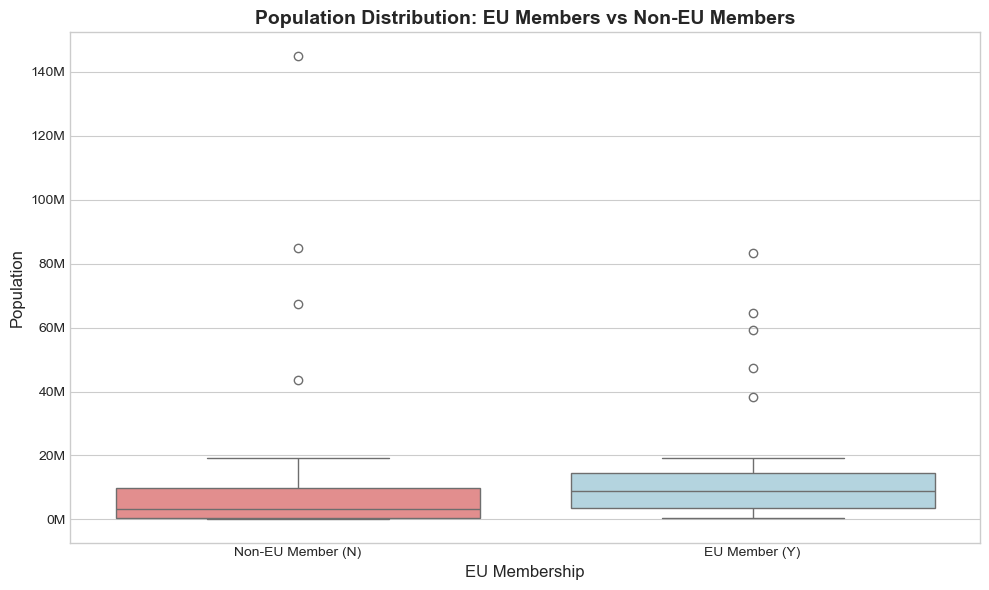


Population Statistics by EU Membership:
--------------------------------------------------
           count          mean           std       min        25%        50%  \
EU Member                                                                      
N           23.0  1.826940e+07  3.552614e+07     511.0   499097.0  3270943.0   
Y           27.0  1.648338e+07  2.205241e+07  526748.0  3423393.0  8922082.0   

                  75%          max  
EU Member                           
N           9945579.5  145102755.0  
Y          14556557.5   83408554.0  


In [42]:
# Boxplot comparing population of EU members vs non-EU members
plt.figure(figsize=(10, 6))

# Create boxplot using seaborn
ax = sns.boxplot(x='EU Member', y='Population', data=df, hue='EU Member', 
                 palette={'N': 'lightcoral', 'Y': 'lightblue'}, legend=False)

# Customize the plot
plt.title('Population Distribution: EU Members vs Non-EU Members', fontsize=14, fontweight='bold')
plt.xlabel('EU Membership', fontsize=12)
plt.ylabel('Population', fontsize=12)

# Set tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-EU Member (N)', 'EU Member (Y)'])

# Format y-axis to show numbers in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))

plt.tight_layout()
plt.show()

# Statistics by EU membership
print("\nPopulation Statistics by EU Membership:")
print("-" * 50)
print(df.groupby('EU Member')['Population'].describe())

## 8. Population vs Area Scatter Plot

Generate a scatter plot with Area (km2) on x-axis and Population on y-axis.

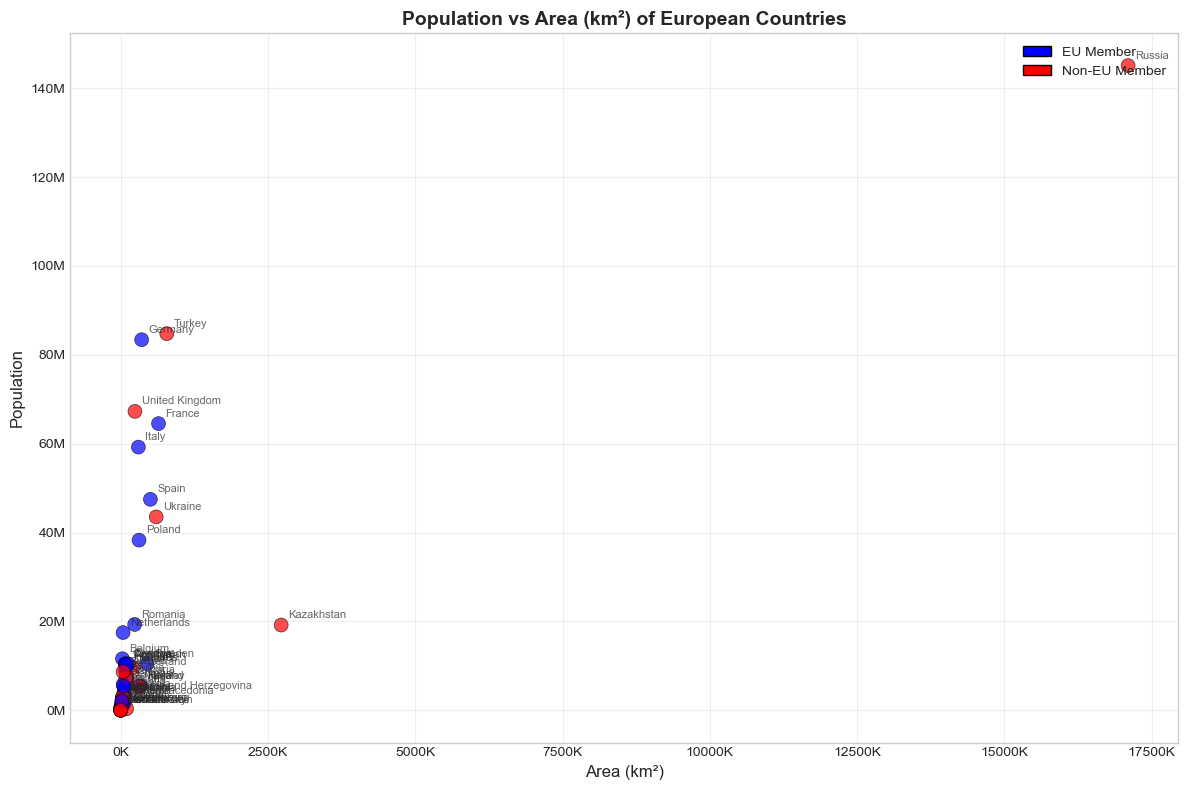


Correlation between Area and Population: 0.6825


In [43]:
# Scatter plot: Population vs Area (km2)
plt.figure(figsize=(12, 8))

# Create scatter plot with different colors for EU/non-EU members
colors = df['EU Member'].map({'Y': 'blue', 'N': 'red'})
plt.scatter(df['Area (km2)'], df['Population'], c=colors, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

# Add labels for each country
for idx, row in df.iterrows():
    plt.annotate(row['English Common Name'], 
                 (row['Area (km2)'], row['Population']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8, alpha=0.7)

# Customize the plot
plt.title('Population vs Area (km²) of European Countries', fontsize=14, fontweight='bold')
plt.xlabel('Area (km²)', fontsize=12)
plt.ylabel('Population', fontsize=12)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', edgecolor='black', label='EU Member'),
                   Patch(facecolor='red', edgecolor='black', label='Non-EU Member')]
plt.legend(handles=legend_elements, loc='upper right')

# Format axes
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add correlation line
print(f"\nCorrelation between Area and Population: {df['Area (km2)'].corr(df['Population']):.4f}")

## 9. Summary and Conclusions

Final summary of the scraped data and analysis results.

In [44]:
# Final Summary
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   - Total Countries Scraped: {len(df)}")
print(f"   - EU Member Countries: {(df['EU Member'] == 'Y').sum()}")
print(f"   - Non-EU Member Countries: {(df['EU Member'] == 'N').sum()}")

print(f"\n📏 AREA STATISTICS (km²):")
print(f"   - Average Area: {df['Area (km2)'].mean():,.2f} km²")
print(f"   - Median Area: {df['Area (km2)'].median():,.2f} km²")
print(f"   - Largest Country: {df.loc[df['Area (km2)'].idxmax(), 'English Common Name']} ({df['Area (km2)'].max():,.0f} km²)")
print(f"   - Smallest Country: {df.loc[df['Area (km2)'].idxmin(), 'English Common Name']} ({df['Area (km2)'].min():,.0f} km²)")

print(f"\n👥 POPULATION STATISTICS:")
print(f"   - Average Population: {df['Population'].mean():,.0f}")
print(f"   - Median Population: {df['Population'].median():,.0f}")
print(f"   - Most Populous: {df.loc[df['Population'].idxmax(), 'English Common Name']} ({df['Population'].max():,.0f})")
print(f"   - Least Populous: {df.loc[df['Population'].idxmin(), 'English Common Name']} ({df['Population'].min():,.0f})")

print(f"\n📈 CORRELATION ANALYSIS:")
print(f"   - Correlation (Area vs Population): {df['Area (km2)'].corr(df['Population']):.4f}")

print("\n" + "=" * 70)
print("Data collection and analysis complete!")
print("=" * 70)

FINAL SUMMARY

📊 DATASET OVERVIEW:
   - Total Countries Scraped: 50
   - EU Member Countries: 27
   - Non-EU Member Countries: 23

📏 AREA STATISTICS (km²):
   - Average Area: 535,875.51 km²
   - Median Area: 69,986.50 km²
   - Largest Country: Russia (17,098,242 km²)
   - Smallest Country: Vatican City (0 km²)

👥 POPULATION STATISTICS:
   - Average Population: 17,304,945
   - Median Population: 5,695,116
   - Most Populous: Russia (145,102,755)
   - Least Populous: Vatican City (511)

📈 CORRELATION ANALYSIS:
   - Correlation (Area vs Population): 0.6825

Data collection and analysis complete!
